# CC's LSTM for stock prediction

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

## Hyper parameters

In [5]:
# for dataset splitting
TRAIN_RATIO = 8
VALIDATION_RATIO = 1
TEST_RATIO = 1

# Using previous 60 days data to predict next 7 days close price
## time window size
TIME_WINDOW_SIZE = 60
## feature size
NFEATURES = 40
## forescast size
FORECAST_SIZE = 7

# Model related parameters
BATCH_SIZE = 4 # for LSTM, don't use large batch_size
EPOCH = 50

# Train related parameters
MODEL_SAVED_PATH = "./saved_model/exp_2/"
init_epoch = 0

## Load dataset from csv and split train, validation and test dataset (8:1:1)

In [6]:
dataset_df = pd.read_csv("./data/dataset.csv")
# dataset_df

In [7]:
# transfer pandas dataframe to numpy ndarray
dataset_np = np.array(dataset_df.iloc[:, 1:])
dataset_np.shape

(2517, 40)

In [8]:
# split train, validation and test
dataset_size = dataset_np.shape[0]
dataset_segment = dataset_size // 10
train_dataset = dataset_np[:TRAIN_RATIO * dataset_segment]
validation_dataset = dataset_np[TRAIN_RATIO * dataset_segment: (TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment]
test_dataset = dataset_np[(TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment:]

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 40), (251, 40), (258, 40))

## Define data normalization function

In [9]:
def normalize_by_column_within_time_window(x, y):
  # x.shape = (window_size, 40)
  # y.shape = (forecast_size)
  EPS = 1e-5
  ret_x = np.array(x)
  ret_y = np.array(y)

  train_close_price_min = np.min(ret_x[:, 3]) # the 3th column of x is the close price
  train_close_price_max = np.max(ret_x[:, 3])

  for i in range(ret_x.shape[1]):
    column_min = np.min(ret_x[:, i])
    column_max = np.max(ret_x[:, i])
    ret_x[:, i] = (ret_x[:, i] - column_min) / (column_max - column_min + EPS)  # EPS for value stability (x / 0.000000000000000001 will be huge)

  
  ret_y = (ret_y - train_close_price_min) / (train_close_price_max - train_close_price_min + EPS)
  
  return ret_x, ret_y

In [59]:
# # fix every column into [0, 1)
# train_data_norm = normalize_by_column(train_dataset)
# validation_dataset_norm = normalize_by_column(validation_dataset)
# test_dataset_norm = normalize_by_column(test_dataset)

In [60]:
# np.min(train_data_norm[:, 0]), np.max(train_data_norm[:, 0])

## Define Kears data generator (keras.utils.Sequence)

In [10]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataset, batch_size, window_size, forecast_size, shuffle=False):
    self.dataset = dataset  # shape = (n, features)
    self.batch_size = batch_size
    self.window_size = window_size
    self.forecast_size = forecast_size

    self.x = []             # final x.shape = (-1, window_size, features)
    self.y = []             # final y.shape = (-1, forecast_size)
    for i in range(self.dataset.shape[0] - window_size - forecast_size):
      # cur_x: dataset[i: i + window_size], shape = (window_size, nfeatures)
      # cur_y: dataset[i + window_size: i + window_size + forecast_size, 3], shape = shape = (window_size, 1)
      # normalize_by_column_within_time_window fix x and y to around [0, 1]
      cur_x, cur_y = normalize_by_column_within_time_window(dataset[i: i + window_size, :], dataset[i + window_size: i + window_size + forecast_size, 3].reshape(-1, forecast_size))

      # cur_x = dataset[i: i + window_size, :]
      # cur_y = dataset[i + window_size: i + window_size + forecast_size, 3]

      self.x.append(cur_x)
      self.y.append(cur_y)
      
    self.x = np.array(self.x)
    self.y = np.array(self.y).reshape(-1, forecast_size)
    
    if shuffle:
      shuffle_idx = np.random.permutation(self.x.shape[0])
      self.x = self.x[shuffle_idx, :, :]
      self.y = self.y[shuffle_idx, :]

  def __len__(self):
    return self.x.shape[0] // self.batch_size

  def __getitem__(self, idx):
    # return one batch data 
    # x: (batch_size, window_size, features)
    # y: (batch_size, forecast_size, 1)
    batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]

    return batch_x, batch_y

In [11]:
train_gen = DataGenerator(dataset=train_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=True)
valid_gen = DataGenerator(dataset=validation_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)
test_gen = DataGenerator(dataset=test_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)

In [12]:
train_batch_x, train_batch_y = train_gen[0]
train_batch_x.shape, train_batch_y.shape
# should be (batch, window_size, nfeatures) and (batch, forecast_size)

((4, 60, 40), (4, 7))

In [13]:
train_batch_y[0]

array([0.34721996, 0.38194167, 0.4360351 , 0.5628617 , 0.59502497,
       0.73464382, 0.6699513 ])

## Define sequential model and train related stuff

In [14]:
class LSTMPredictor(keras.Model):

  def __init__(self, input_shape, forecast_size): 
    # input shape should be (batch, window_size, features)
    super().__init__()

    self.lstm1 = keras.layers.LSTM(10, activation="sigmoid", input_shape=input_shape, return_sequences=True)  # (batch, window_size, 10)
    self.dropout1 = keras.layers.Dropout(0.1)

    self.lstm2 = keras.layers.LSTM(32, activation="sigmoid", return_sequences=True) # (batch, window_size, 32)
    self.dropout2 = keras.layers.Dropout(0.1)

    self.lstm3 = keras.layers.LSTM(64, activation="sigmoid", return_sequences=True) # (batch, window_size, 64)
    self.dropout3 = keras.layers.Dropout(0.1)

    self.lstm4 = keras.layers.LSTM(32, activation="sigmoid", return_sequences=True) # (batch, window_size, 32)
    self.dropout4 = keras.layers.Dropout(0.1)

    self.lstm5 = keras.layers.LSTM(forecast_size, activation="relu", return_sequences=False) # (batch, forecast_size)
    self.dense5 = keras.layers.Dense(forecast_size) # (batch, forecast_size)
  
  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dropout1(x)
    x = self.lstm2(x)
    x = self.dropout2(x)
    x = self.lstm3(x)
    x = self.dropout3(x)
    x = self.lstm4(x)
    x = self.dropout4(x)

    x = self.lstm5(x)
    x = self.dense5(x)
    return x

In [15]:
model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

model.compile(optimizer=adam, loss="mse", metrics=["mape"])
model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))
model.summary()

2022-11-10 19:00:47.275551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 19:00:47.275594: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 19:00:47.275618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-24-249): /proc/driver/nvidia/version does not exist
2022-11-10 19:00:47.275844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning:

Model: "lstm_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  2040      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  5504      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 lstm_2 (LSTM)               multiple                  24832     
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 lstm_3 (LSTM)               multiple               

In [16]:
# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=MODEL_SAVED_PATH + 'LSTM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=MODEL_SAVED_PATH + 'LSTM_training_log.csv',
                       separator=',',
                       append=True)

def lr_schedule(epoch):
    if epoch < 20:
        return 0.001
    elif epoch < 40:
        return 0.0001
    else:
        return 0.00001

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## Train

In [17]:
!ls

60-7-model.ipynb  Prophet.ipynb			 data
Dataset1.ipynb	  SentimentAnalysis.ipynb	 open_sourced_github_projs
Dataset2.ipynb	  StockHistoricalData		 raw_analyst_ratings.csv
Dataset3.ipynb	  TechnicalIndicator.ipynb	 readme.md
Figures		  Untitled.ipynb		 saved_model
LSTM.ipynb	  Untitled1.ipynb		 us_equities_news_dataset.csv
MACD.csv	  analyst_ratings_processed.csv
MACD_fig.png	  cc_msc.ipynb


In [18]:
history = model.fit(train_gen, 
                    epochs=EPOCH,
                    validation_data=valid_gen,
                    callbacks=callbacks,
                    initial_epoch=init_epoch);


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
485/485 [==============================] - ETA: 0s - loss: 0.3111 - mape: 62407.9531
Epoch 1: val_loss improved from inf to 0.08901, saving model to ./saved_model/exp_2/LSTM_epoch-01_loss-0.3111_val_loss-0.0890.h5
485/485 [==============================] - 54s 100ms/step - loss: 0.3111 - mape: 62407.9531 - val_loss: 0.0890 - val_mape: 53.5850 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
485/485 [==============================] - ETA: 0s - loss: 0.0803 - mape: 20039.1074
Epoch 2: val_loss improved from 0.08901 to 0.06243, saving model to ./saved_model/exp_2/LSTM_epoch-02_loss-0.0803_val_loss-0.0624.h5
485/485 [==============================] - 48s 98ms/step - loss: 0.0803 - mape: 20039.1074 - val_loss: 0.0624 - val_mape: 38.6464 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
485/485 [==============================] - ETA: 0s - los

KeyboardInterrupt: 

## Inference

In [19]:
# load model
model_name = "LSTM_epoch-04_loss-0.0648_val_loss-0.0479.h5"
weight_path = os.path.join(MODEL_SAVED_PATH, model_name)
pred_model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)
pred_model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))

pred_model.load_weights(weight_path)

In [20]:
def inference(model, test_data):
  # test_data should be (window_size, 40)
  EPS = 1e-5
  close_price_min = np.min(test_data[:, 3]) # the 3th column of x is the close price
  close_price_max = np.max(test_data[:, 3]) # the 3th column of x is the close price
  for i in range(test_data.shape[1]):
    column_min = np.min(test_data[:, i])
    column_max = np.max(test_data[:, i])
    test_data[:, i] = (test_data[:, i] - column_min) / (column_max - column_min + EPS)

  y_pred = model.predict(test_data.reshape(1, test_data.shape[0], test_data.shape[1]))
  print(y_pred.shape)
  y_pred = y_pred * (close_price_max - close_price_min + EPS) + close_price_min
  return y_pred.reshape(-1)

In [21]:
test_x, test_y = test_gen[0]
test_x.shape, test_y.shape

((4, 60, 40), (4, 7))

In [22]:
def draw_inference(model, test_data, test_label):
  y_pred = inference(model, test_data)
  y_history = test_data[:, 3] # the 3th cloumn is the close price
  x_idxs = np.arange(test_data.shape[0] + test_label.shape[0], dtype=np.int32)

  plt.scatter(x_idxs[:test_data.shape[0]], y_history, marker="*")
  plt.plot(x_idxs[:test_data.shape[0]], y_history)

  plt.scatter(x_idxs[test_data.shape[0]: ], test_label, marker="D")
  plt.plot(x_idxs[test_data.shape[0]: ], test_label)

  plt.scatter(x_idxs[test_data.shape[0]: ], y_pred, marker="+")
  plt.plot(x_idxs[test_data.shape[0]: ], y_pred)

1/1 [==============================] - 1s 714ms/step
(1, 7)


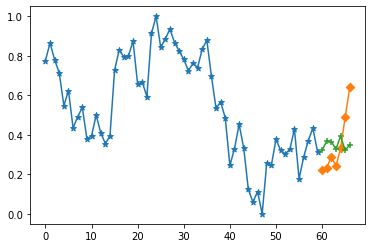

In [23]:
draw_inference(pred_model, test_x[2], test_y[2])

1/1 [==============================] - 0s 42ms/step
(1, 7)


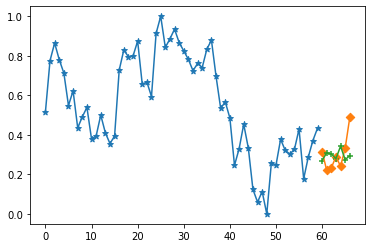

In [24]:
draw_inference(pred_model, test_x[1], test_y[1])